# Project 2


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time
import torchvision

from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

/home/vm/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the dataset CIFAR10

We are told to classify birds from cats in the CIFAR10 dataset. This means that we will only use the images that are labeled as birds or cats. In the CIFAR10 these labels are 2 and 3 respectively. We will have the training, validation and test datasets.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)



Files already downloaded and verified
Files already downloaded and verified


#### Filtering by cats and birds

In [3]:
def filter_by_bids_and_cats(trainset):
    trainset.targets = torch.tensor(trainset.targets)    # Convert targets to tensor if not already

    mask = (trainset.targets == 2) | (trainset.targets == 3)     # Create mask to filter birds (label 2) and cats (label 3)
    
    trainset.targets = (trainset.targets[mask] - 2)     # Adjust labels to be 0 for birds and 1 for cats
    
    trainset.data = trainset.data[mask.numpy().astype(bool)] # Filter data and targets based on the mask
    
    return trainset


In [4]:
trainset = filter_by_bids_and_cats(trainset)
testset = filter_by_bids_and_cats(testset)

#### Splitting the training into train and valid (80/20)

In [5]:
# Define the size of the validation set
validation_size = 0.2  # 20% of the training set

# Split the training set into training subset and validation set
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(validation_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_subset = Subset(trainset, train_indices)
val_set = Subset(trainset, val_indices)

In [6]:
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
# shuffle= True as we want the training to be loaded in a random order
# num_workers=2 means that we use 2 sub-processes to load the data

validloader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64,shuffle=False, num_workers=2)
# shuffle= False as we want our evaluation results to be in order, consisten. 


#### Check Splitting Sizes

In [7]:
print('Size of the original trainset:', len(trainset))

print('Size of the training set:', len(train_subset))
print('Size of the validation set:', len(val_set))
print('Size of the testing set:', len(testset))

#i want to see the first 10 rows
dataiter = iter(validloader)
images, labels = next(dataiter)
print("Images shape: ",images.shape) # this is the shape of the image

# [64, 3, 32, 32] 64 images, 3 channels, 32x32 pixels

Size of the original trainset: 10000
Size of the training set: 8000
Size of the validation set: 2000
Size of the testing set: 2000
Images shape:  torch.Size([64, 3, 32, 32])


#### Checking that our input data are birds and cats 

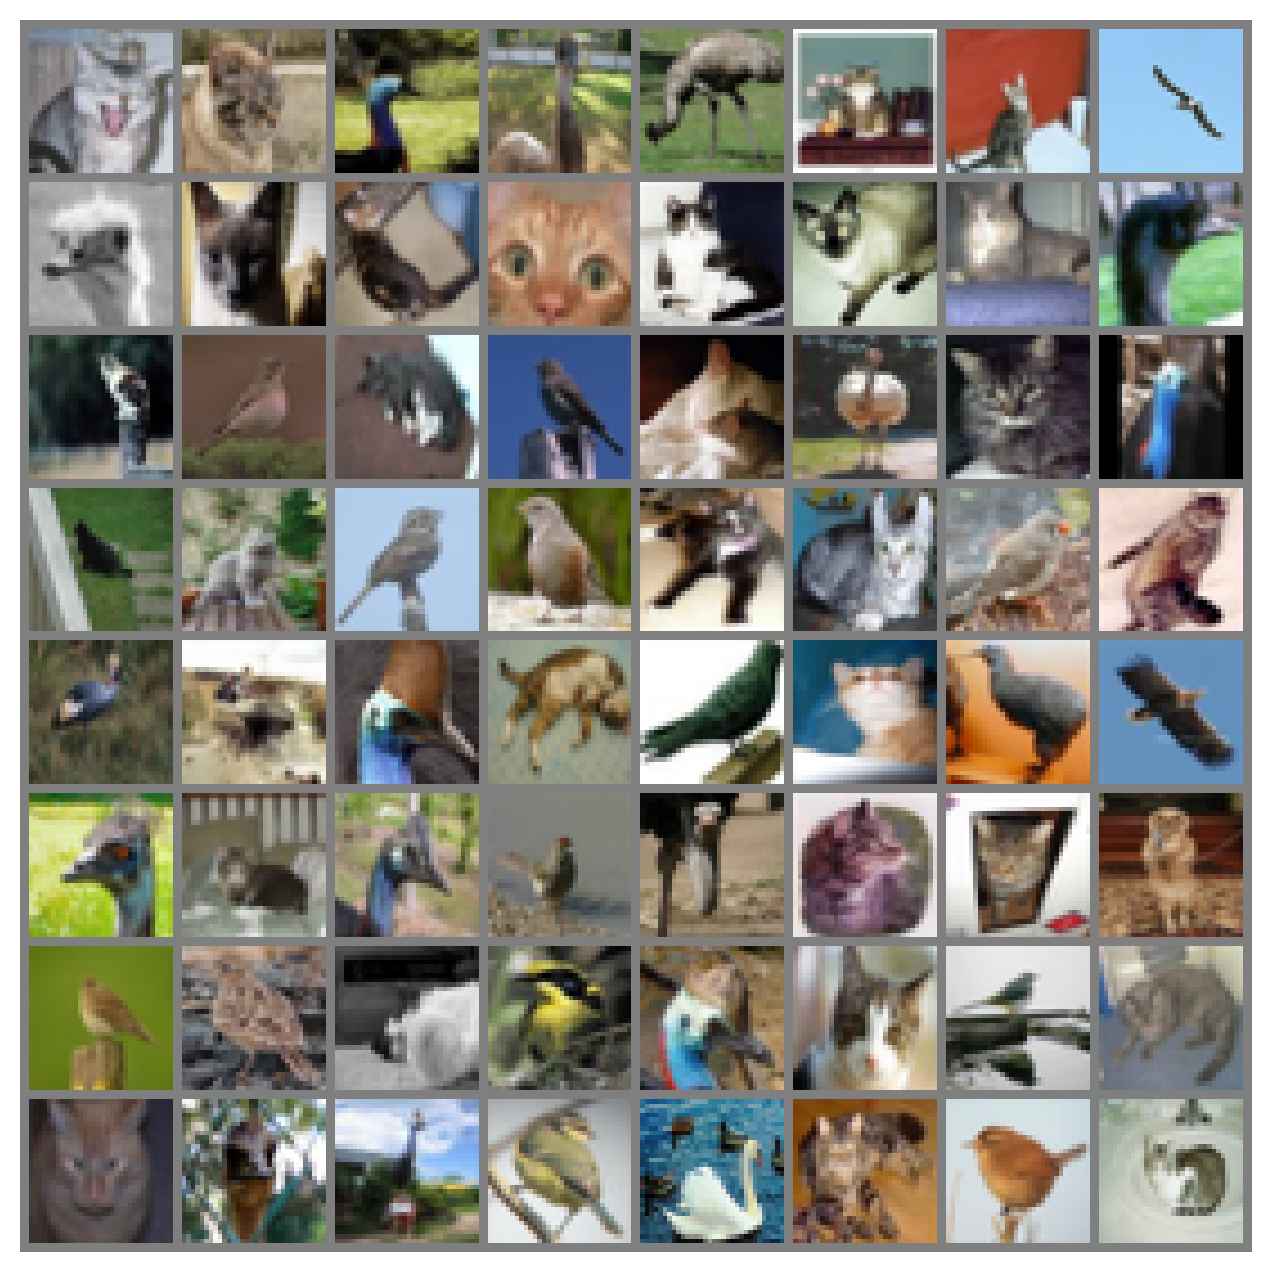

In [8]:
# Define function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))  # Adjust the figure size here
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest') 
    
    plt.axis('off')  # Turn off axis
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images))

## Implementation of a Lenet5

In [9]:
class Lenet5(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_part = nn.Sequential( # As images are rgb we have 3 input channels
            nn.Conv2d(in_channels=3, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # The input dimension at the classifier is 16 images of 5x5 so 16*5*5
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = self.conv_part(x)
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classifier(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)
                #print(torch.exp(outputs))
                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [10]:
model = Lenet5()
model.trainloop(trainloader,validloader,25)


Switching to GPU
Epoch 1. Training loss: 0.579415, Validation loss: 0.532595, Time per epoch: 1.870734 seconds
Epoch 2. Training loss: 0.510741, Validation loss: 0.511918, Time per epoch: 1.524853 seconds
Epoch 3. Training loss: 0.478773, Validation loss: 0.485438, Time per epoch: 1.305252 seconds
Epoch 4. Training loss: 0.460781, Validation loss: 0.461121, Time per epoch: 1.491769 seconds
Epoch 5. Training loss: 0.430547, Validation loss: 0.471661, Time per epoch: 1.641039 seconds
Epoch 6. Training loss: 0.418444, Validation loss: 0.475918, Time per epoch: 1.343494 seconds
Epoch 7. Training loss: 0.392863, Validation loss: 0.447758, Time per epoch: 1.932607 seconds
Epoch 8. Training loss: 0.375157, Validation loss: 0.465691, Time per epoch: 1.628236 seconds
Epoch 9. Training loss: 0.356211, Validation loss: 0.460078, Time per epoch: 1.388576 seconds
Epoch 10. Training loss: 0.328204, Validation loss: 0.460581, Time per epoch: 1.377891 seconds
Epoch 11. Training loss: 0.312045, Validat

8 epochs for early stopping

## Computing the Calibration Curve

In [13]:
# First we select the true labels of the test data
true_labels = validloader.dataset.targets.numpy()

# The store the output value of the model for each image in the test set
ac, outputs = model.compute_accuracy(validloader)
outputs_cpu = [output.cpu().numpy() for output in outputs] # ALEJO: I added this line to move the tensors to the CPU
outputs = np.concatenate(outputs_cpu) # concatenate the list of tensors into a single tensor

# Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]

print(predicted_prob)
print(max(predicted_prob))

[0.9985714, 0.91460013, 0.0044367723, 0.96055335, 0.0236964, 0.99896294, 0.99988973, 8.079173e-06, 0.0007957882, 1.2995299e-12, 0.0019923241, 1.5718282e-05, 7.985996e-05, 0.99999905, 0.9999993, 0.010006945, 0.6970473, 0.10946772, 0.9999989, 0.9941486, 0.0055124974, 0.9982437, 0.9965035, 0.32672918, 0.001029498, 0.9998393, 0.00018639851, 0.28287542, 0.002658291, 1.0, 0.9935171, 0.0003069926, 3.2280865e-09, 2.5240977e-05, 1.0, 6.964795e-06, 5.7282264e-06, 0.9981628, 0.35769, 7.3523834e-06, 0.99966264, 3.5692777e-12, 0.99983907, 0.9999983, 9.059977e-12, 0.37540847, 0.9979973, 0.86240566, 0.19697613, 0.3953785, 0.42039052, 0.11674519, 0.8972771, 0.9999988, 0.08878089, 0.9999983, 0.005881534, 0.0002216427, 0.00021231198, 0.99730754, 8.758584e-06, 0.9614881, 0.095007665, 0.9910367, 0.2033673, 0.00011081083, 1.1310709e-08, 0.1030113, 0.20969836, 0.022801798, 0.017365376, 4.4469218e-08, 0.91174334, 9.075077e-06, 0.00011262671, 3.5004255e-10, 0.17855562, 0.760394, 0.99998665, 0.9993994, 5.64803

True labels:  [0.20740741 0.46774194 0.44117647 0.51851852 0.63888889 0.64705882
 0.55       0.75757576 0.66666667 0.8277635 ] 

Predicted Probabilities: [0.00665135 0.15101388 0.24685327 0.34519282 0.45295604 0.54635504
 0.6533937  0.76177098 0.85785691 0.9908968 ]


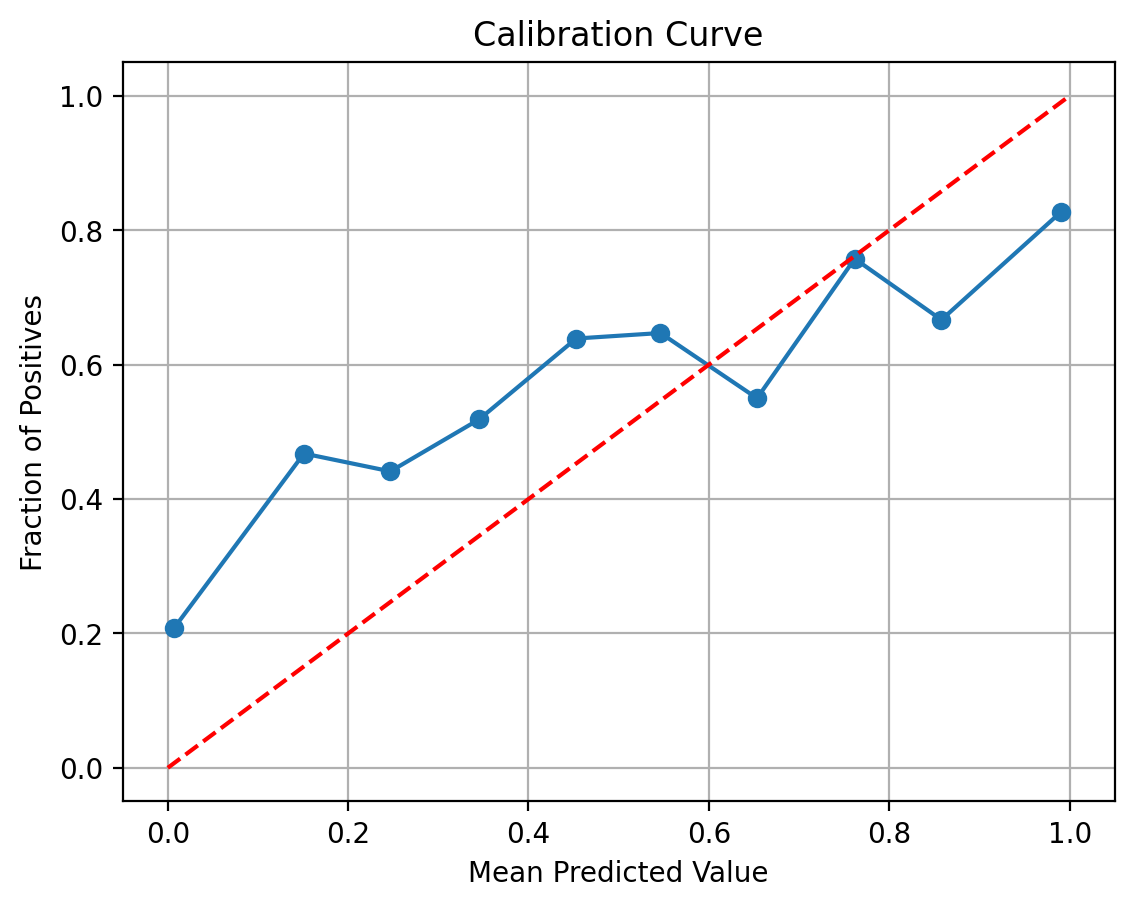

In [14]:
from sklearn.calibration import calibration_curve


prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [15]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.1634


Lenet5 regularized


In [16]:
class Lenet5_regularized(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_part = nn.Sequential( # As images are rgb we have 3 input channels
            nn.Conv2d(in_channels=3, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # The input dimension at the classifier is 16 images of 5x5 so 16*5*5
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = self.conv_part(x)
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classifier(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [17]:
model = Lenet5_regularized()
model.trainloop(trainloader,validloader,8)

Switching to GPU


Epoch 1. Training loss: 0.594080, Validation loss: 0.528982, Time per epoch: 2.450163 seconds
Epoch 2. Training loss: 0.502300, Validation loss: 0.497629, Time per epoch: 2.334161 seconds
Epoch 3. Training loss: 0.460499, Validation loss: 0.515246, Time per epoch: 2.271372 seconds
Epoch 4. Training loss: 0.440620, Validation loss: 0.483900, Time per epoch: 2.303802 seconds
Epoch 5. Training loss: 0.428151, Validation loss: 0.461789, Time per epoch: 2.406364 seconds
Epoch 6. Training loss: 0.408686, Validation loss: 0.465268, Time per epoch: 2.605420 seconds
Epoch 7. Training loss: 0.389198, Validation loss: 0.463636, Time per epoch: 2.473156 seconds
Epoch 8. Training loss: 0.370917, Validation loss: 0.454617, Time per epoch: 2.399090 seconds


In [18]:
# First we select the true labels of the test data
true_labels = validloader.dataset.targets.numpy()

# The store the output value of the model for each image in the test set
ac, outputs = model.compute_accuracy(validloader)
outputs_cpu = [output.cpu().numpy() for output in outputs] # ALEJO: I added this line to move the tensors to the CPU

outputs = np.concatenate(outputs_cpu) # concatenate the list of tensors into a single tensor

# Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]

True labels:  [0.06134969 0.12154696 0.18705036 0.27272727 0.45631068 0.30275229
 0.59292035 0.65326633 0.81229773 0.90997567] 

Predicted Probabilities: [0.04744675 0.14818168 0.25101273 0.34783348 0.44736649 0.5445527
 0.65215367 0.75550448 0.8559272  0.94974438]


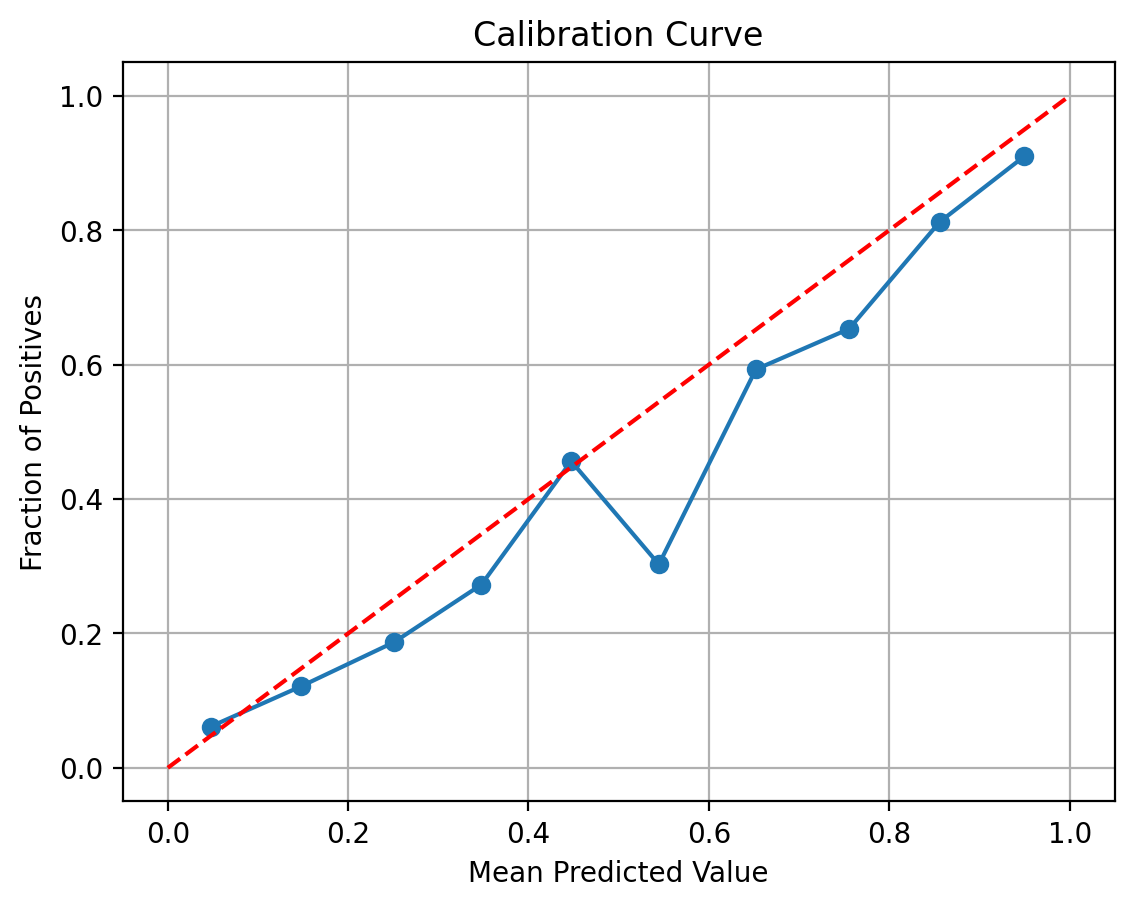

In [19]:
prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [20]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0675


# Platt scaling

For Platt scaling we have to enter our outputs (the ones obtained for the true class) multiplied by a constant a into a new sigmoid

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Fitting a logistic regression model
lr = LogisticRegression()
lr.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Platt scaling using CalibratedClassifierCV
platt_scale = CalibratedClassifierCV(lr, method='sigmoid', cv='prefit')
platt_scale.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Applying Platt scaling
platt_scaled_probs = platt_scale.predict_proba(np.array(predicted_prob).reshape(-1, 1))[:, 1]



True labels:  [0.06203474 0.17573222 0.28813559 0.43820225 0.31182796 0.51388889
 0.59016393 0.71428571 0.88330632 1.        ] 

Predicted Probabilities: [0.07077909 0.14352846 0.24599855 0.3469189  0.44953126 0.55127637
 0.65259152 0.7558147  0.85766507 0.90034897]


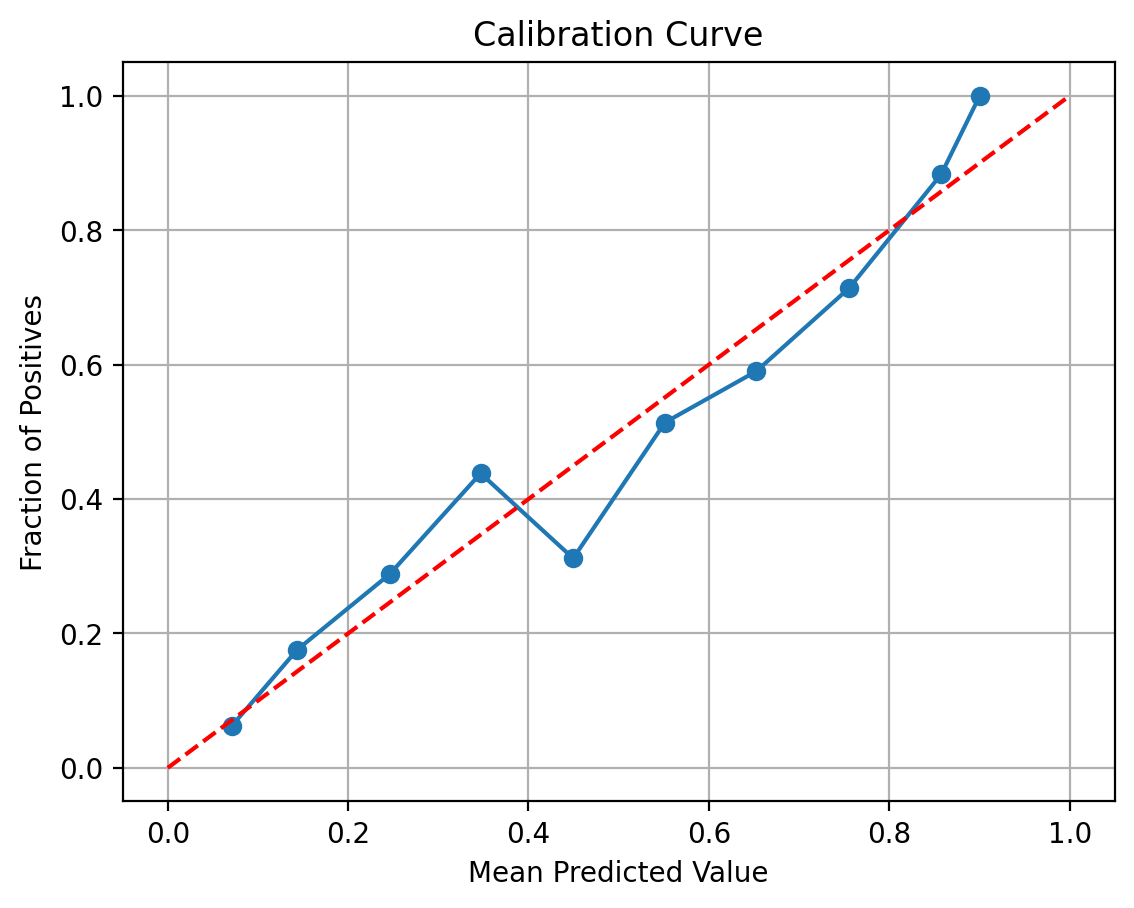

In [22]:
prob_true, prob_pred = calibration_curve(true_labels, platt_scaled_probs, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [23]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0579


# Optional part

We will use a pre-trained model, in this case, the DenseNet

In [24]:
from torchvision import models
model = models.densenet121(pretrained=True)

/home/vm/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vm/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We will change the classifier part of the DenseNet by the one we have also used in Lenet5 for the classification part


In [25]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.classify = nn.Sequential(
            nn.Linear(1024, 120), # The input dimension at the classifier is 1024, see DenseNet
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classify(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [26]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = Classifier()

model.classifier = classifier

Switching to GPU


Class for training the new model

In [27]:
class Tran_Eval():


    def __init__(self,model,maxiter=30,lr=0.001):

        self.model = model

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)

        self.max_iter = maxiter

        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)

    def trainloop(self,trainloader):

        # Optimization Loop

        it_images = iter(trainloader)

        running_loss = 0.

        self.model.train()

        for e in range(int(self.max_iter)):


            images,labels = next(it_images)


            # Move input and label tensors to the default device
            images, labels = images.to(self.device), labels.to(self.device)

            self.optim.zero_grad()  #TO RESET GRADIENTS!

            out = self.model.forward(images) #YOUR CODE HERE


            loss = self.criterion(out,labels) #YOUR CODE HERE

            running_loss = loss.item()

            #Your code here
            loss.backward()

            #Your code here
            self.optim.step()

            self.loss_during_training.append(running_loss)

            print('Epoch %d of %d finished. Loss %f' %(e+1,self.max_iter,running_loss))


    def compute_accuracy(self,model, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.model.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model.forward(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list

In [28]:
model_with_train = Tran_Eval(model,maxiter=10)

In [29]:
model_with_train.trainloop(trainloader)

Epoch 1 of 10 finished. Loss 0.692473
Epoch 2 of 10 finished. Loss 0.714602
Epoch 3 of 10 finished. Loss 0.690163
Epoch 4 of 10 finished. Loss 0.678882
Epoch 5 of 10 finished. Loss 0.670628
Epoch 6 of 10 finished. Loss 0.665217
Epoch 7 of 10 finished. Loss 0.655007
Epoch 8 of 10 finished. Loss 0.655062
Epoch 9 of 10 finished. Loss 0.668988
Epoch 10 of 10 finished. Loss 0.632871


In [30]:
# First we select the true labels of the test data
true_labels = validloader.dataset.targets.numpy()

# The store the output value of the model for each image in the test set
ac, outputs = model_with_train.compute_accuracy(model,validloader)
outputs_cpu = [output.cpu().numpy() for output in outputs] # ALEJO: I added this line to move the tensors to the CPU
outputs = np.concatenate(outputs_cpu) # concatenate the list of tensors into a single tensor

# Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]

True labels:  [0.075      0.20897616 0.65080972 0.92156863 0.93333333] 

Predicted Probabilities: [0.37829508 0.4588846  0.54392357 0.62874873 0.72603695]


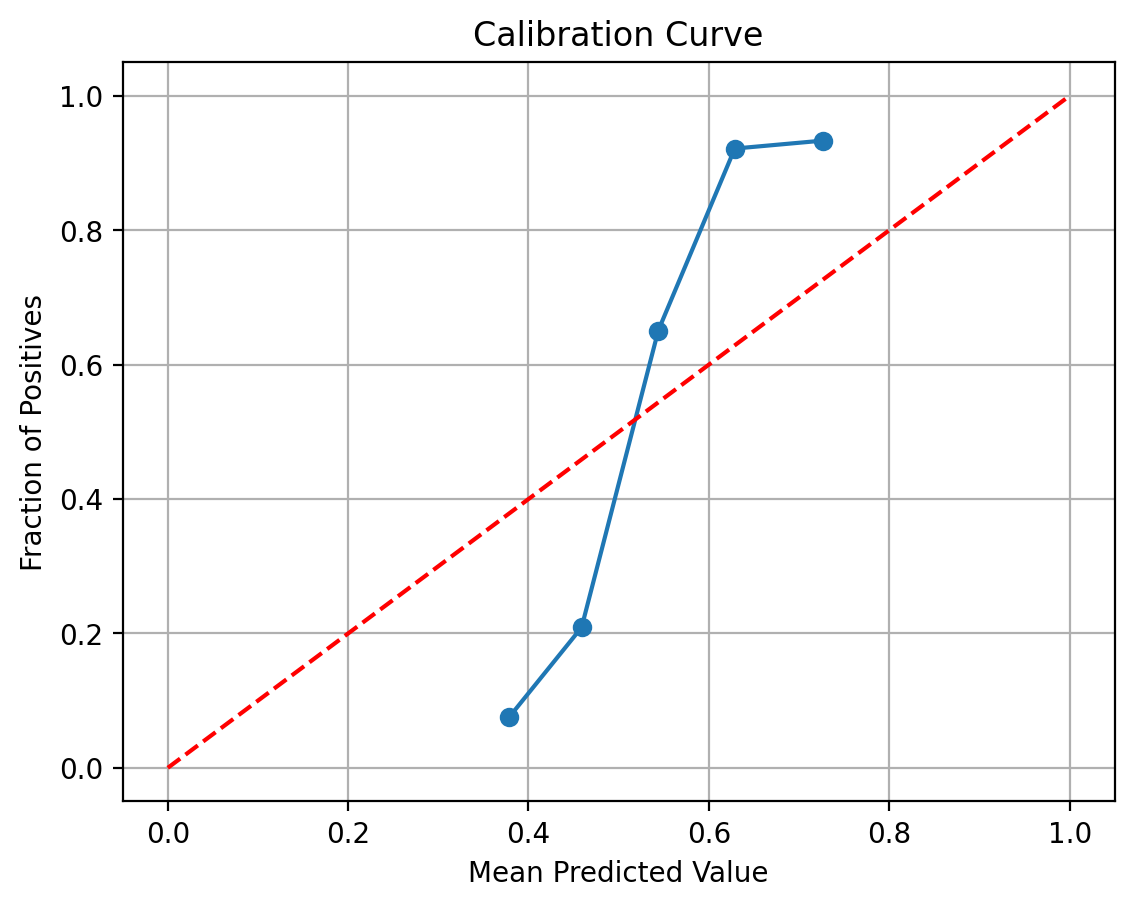

In [31]:
prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [32]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.2320


We add now Platt scaling

In [33]:
# Fitting a logistic regression model
lr = LogisticRegression()
lr.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Platt scaling using CalibratedClassifierCV
platt_scale = CalibratedClassifierCV(lr, method='sigmoid', cv='prefit')
platt_scale.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Applying Platt scaling
platt_scaled_probs = platt_scale.predict_proba(np.array(predicted_prob).reshape(-1, 1))[:, 1]

True labels:  [0.0862069  0.1460177  0.20812183 0.33673469 0.43333333 0.52879581
 0.65775401 0.78111588 0.88095238 0.92613636] 

Predicted Probabilities: [0.06038033 0.14565799 0.24736265 0.34713303 0.44677116 0.55153293
 0.65163183 0.74738708 0.85043933 0.94348454]


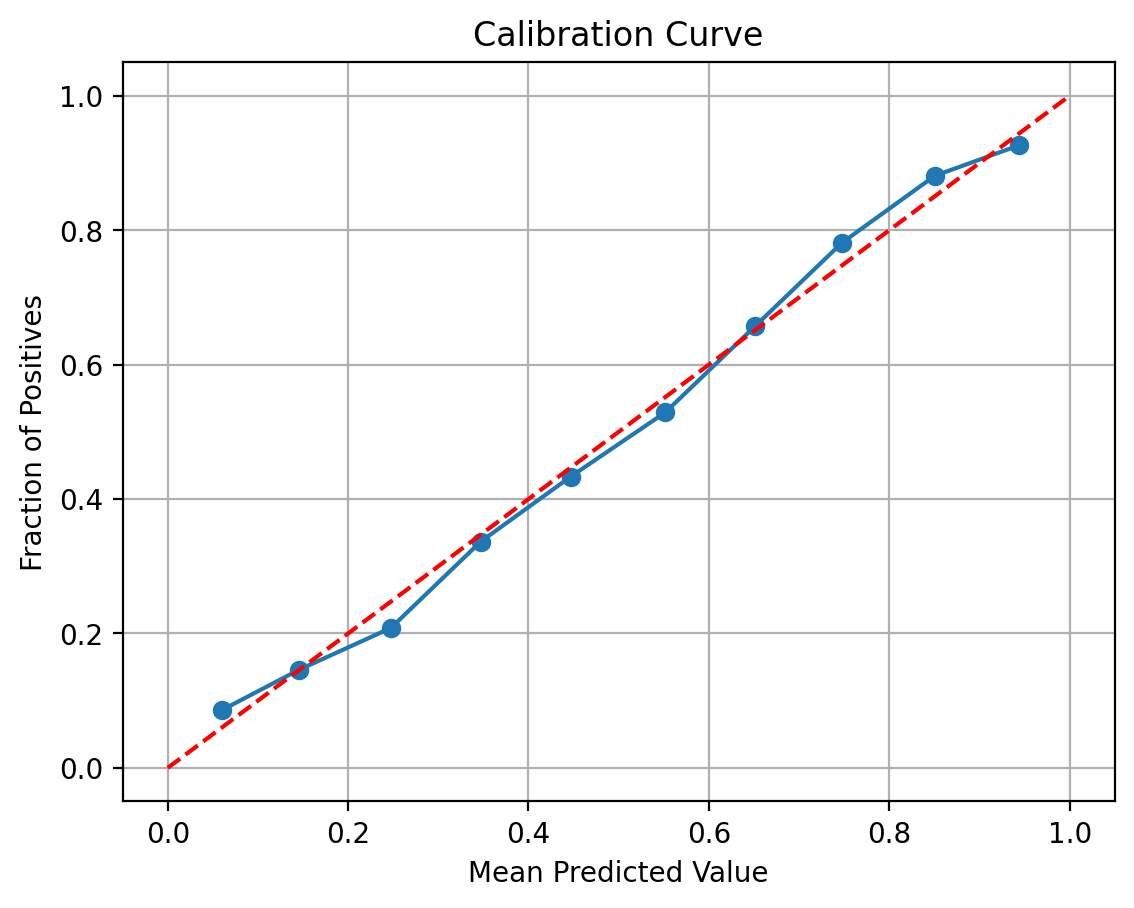

In [34]:
prob_true, prob_pred = calibration_curve(true_labels, platt_scaled_probs, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [35]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0200
